# Load necessary Python libraries

In [0]:
pip install SimpleITK

     |████████████████████████████████| 42.5MB 71kB/s 


In [0]:
pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 40kB/s 
     |████████████████████████████████| 3.8MB 36.0MB/s 
     |████████████████████████████████| 450kB 35.6MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exist

In [0]:
!pip install tensorflow_addons

     |████████████████████████████████| 993kB 5.0MB/s 
     |████████████████████████████████| 421.8MB 33kB/s 
     |████████████████████████████████| 3.8MB 37.2MB/s 
     |████████████████████████████████| 450kB 48.5MB/s 
ERROR: tensorflow-gpu 2.0.0 has requirement tensorboard<2.1.0,>=2.0.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow-gpu 2.0.0 has requirement tensorflow-estimator<2.1.0,>=2.0.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Success

In [0]:
!nvidia-smi

Fri Jan 10 23:33:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount your Google Drive

In [0]:
from google.colab import drive
drive.mount('M_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at M_drive


# Import necessary libraries to environment

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import SimpleITK as itk
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from os.path import join
from PIL import Image  
import PIL  

%matplotlib notebook
%matplotlib inline

import cv2

import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model,load_model

from tensorflow.keras.optimizers import Adam
from os.path import join
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from keras import backend as K



#rezerviramo samo toliko spomina kot ga potrebujemo za učenje
#ce tega ne naredimo se rezervira ves spomin
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config) #v verziji 2 so določene funkcije odstranjene zato malo drugačen klic

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


# Load training and validation data

In [0]:
path="M_drive/My Drive/SeminarAMS/"
X_train=np.load(path+"dataset_MRI_real/dataset_split/X_train/.npy")
X_test=np.load(path+"dataset_MRI_real/dataset_split/X_test/.npy")
y_train=np.load(path+"dataset_MRI_real/dataset_split/y_train/.npy")
y_test=np.load(path+"dataset_MRI_real/dataset_split/y_test/.npy")
print(y_train.shape)

(4000, 252, 252, 3)


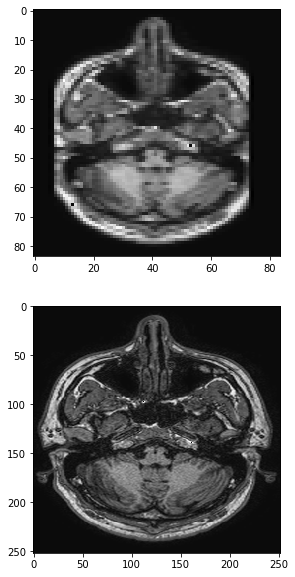

In [0]:
# Check if training data looks all right
ix = random.randint(0, X_train.shape[0])

f, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(10, 10))
plt.subplot(211)
plt.imshow(X_train[ix][:,:,0], cmap='gray')
plt.subplot(212)
plt.imshow(y_train[ix][:,:,0],cmap='gray')

# Functions for build neural network architecture

In [0]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
tf.compat.v1.enable_eager_execution()
MEAN = np.array([0.5, 0.5, 0.5]) * 255


def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def normalize(x):
    return (x - MEAN) / 127.5


def denormalize(x):
    return x * 127.5 + MEAN


from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from os.path import join

import os

import matplotlib.pyplot as plt

#rezerviramo samo toliko spomina kot ga potrebujemo za učenje
#ce tega ne naredimo se rezervira ves spomin
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config) #v verziji 2 so določene funkcije odstranjene zato malo drugačen klic

# Functions for extra crop, rotate and flip data

In [0]:
import tensorflow as tf

from tensorflow.python.data.experimental import AUTOTUNE
def dataset(lr,hr,scale,batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.from_tensor_slices((lr, hr))
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=scale), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)


In [0]:
#verzion 1 -> extra crop,rotate and crop
#ds=dataset(X_train,y_train,3,batch_size=16)#slike zmanjšamo za 3x jih rotiramo, obreženo in zrcalimo


#verzion 2 -> just making batches
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds = ds.batch(2)
ds = ds.repeat(None)
ds = ds.prefetch(buffer_size=AUTOTUNE)


In [0]:
for lr, hr in ds.take(2):
    print(lr.shape)
    print(hr.shape)

# Build EDSR model architecture

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Create directory for saving model weights
path="M_drive/My Drive/SeminarAMS/"
weights_dir =path+'weights_SR'
os.makedirs(weights_dir, exist_ok=True)

# EDSR baseline as described in the EDSR paper (1.52M parameters)
model_edsr = edsr(scale=3, num_res_blocks=16)

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss

model_edsr.compile(optimizer=optim_edsr, loss='mean_absolute_error')

#earlystopper = EarlyStopping(patience=5, verbose=1)
#checkpointer = ModelCheckpoint(join('weights_SR', 'weights-edsr-16-x3_300x100_X1.h5'), verbose=1, save_best_only=True)

# povzetek modela
model_edsr.summary()

#rezerviramo samo toliko spomina kot ga potrebujemo za učenje
#ce tega ne naredimo se rezervira ves spomin
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config) #v verziji 2 so določene funkcije odstranjene zato malo drugačen klic

seed = 42
random.seed = seed
np.random.seed = seed

NameError: ignored

# Train EDSR model

In [0]:
model_edsr.fit(ds, epochs=300, steps_per_epoch=1000)


# Save model weights
model_edsr.save_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000.h5'))

Train for 1000 steps
Epoch 1/300
1000/1000 [==============================] - 43s 43ms/step - loss: 19.1547
Epoch 2/300
1000/1000 [==============================] - 30s 30ms/step - loss: 15.4743
Epoch 3/300
1000/1000 [==============================] - 30s 30ms/step - loss: 14.9133
Epoch 4/300
1000/1000 [==============================] - 29s 29ms/step - loss: 14.7590
Epoch 5/300
1000/1000 [==============================] - 31s 31ms/step - loss: 14.5503
Epoch 6/300
1000/1000 [==============================] - 33s 33ms/step - loss: 14.2741
Epoch 7/300
1000/1000 [==============================] - 40s 40ms/step - loss: 14.2079
Epoch 8/300
1000/1000 [==============================] - 23s 23ms/step - loss: 14.2726
Epoch 9/300
1000/1000 [==============================] - 30s 30ms/step - loss: 14.0128
Epoch 10/300
1000/1000 [==============================] - 31s 31ms/step - loss: 14.1513
Epoch 11/300
1000/1000 [==============================] - 15s 15ms/step - loss: 13.9516
Epoch 12/300
1000/10

# Train SRGAN model

In [0]:
path="M_drive/My Drive/SeminarAMS/"
weights_dir =path+'weights_SR'


import sys
sys.path.append(path)
from model import srgan
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from os.path import join
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

# Used in content_loss
mean_squared_error = tf.keras.losses.MeanSquaredError()

# Used in generator_loss and discriminator_loss
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Model that computes the feature map after the 4th convolution 
# before the 5th max-pooling layer in VGG19. This is layer 20 in
# the corresponding Keras model.
vgg = srgan.vgg_54()

# EDSR model used as generator in SRGAN
generator = edsr(scale=3, num_res_blocks=16)
generator.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000.h5'))

# SRGAN discriminator
############## necessary to define HR dimensions###########################
discriminator = srgan.discriminator(HR_SIZE=96)

# Optmizers for generator and discriminator. SRGAN will be trained for
# 200,000 steps and learning rate is reduced from 1e-4 to 1e-5 after
# 100,000 steps
schedule = PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])
generator_optimizer = Adam(learning_rate=schedule)
discriminator_optimizer = Adam(learning_rate=schedule)

def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

@tf.function
def content_loss(hr, sr):
    sr = tf.keras.applications.vgg19.preprocess_input(sr)
    hr = tf.keras.applications.vgg19.preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

@tf.function
def train_step(lr, hr):
    """SRGAN training step.
    
    Takes an LR and an HR image batch as input and returns
    the computed perceptual loss and discriminator loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        # Forward pass
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        # Compute losses
        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    # Compute gradient of perceptual loss w.r.t. generator weights 
    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    # Compute gradient of discriminator loss w.r.t. discriminator weights 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return perc_loss, disc_loss

pls_metric = tf.keras.metrics.Mean()
dls_metric = tf.keras.metrics.Mean()

steps = 200000 #original 200000
step = 0

# Train SRGAN for 200,000 steps.
for lr, hr in ds.take(steps):
    step += 1

    pl, dl = train_step(lr, hr)
    pls_metric(pl)
    dls_metric(dl)

    if step % 50 == 0:
        print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
        pls_metric.reset_states()
        dls_metric.reset_states()
    if step % 1000 == 0:
        generator.save_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000_TUNED.h5'))

generator.save_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000_TUNED.h5'))



80142336/80134624 [==============================] - 3s 0us/step
50/200000, perceptual loss = 0.1102, discriminator loss = 3.3396
100/200000, perceptual loss = 0.1171, discriminator loss = 1.9446
150/200000, perceptual loss = 0.1074, discriminator loss = 0.9229
200/200000, perceptual loss = 0.1057, discriminator loss = 1.0910
250/200000, perceptual loss = 0.1077, discriminator loss = 1.9921
300/200000, perceptual loss = 0.1112, discriminator loss = 0.8594
350/200000, perceptual loss = 0.1161, discriminator loss = 0.5043
400/200000, perceptual loss = 0.1125, discriminator loss = 0.1024
450/200000, perceptual loss = 0.1180, discriminator loss = 0.2943
500/200000, perceptual loss = 0.1204, discriminator loss = 0.1406
550/200000, perceptual loss = 0.1235, discriminator loss = 0.2192
600/200000, perceptual loss = 0.1173, discriminator loss = 0.0592
650/200000, perceptual loss = 0.1258, discriminator loss = 0.0972
700/200000, perceptual loss = 0.1309, discriminator loss = 0.0202
750/200000, 

# Check how model works

(252, 252, 3)
(252, 252, 3)


Text(0.5, 1.0, 'FINE TUNED')

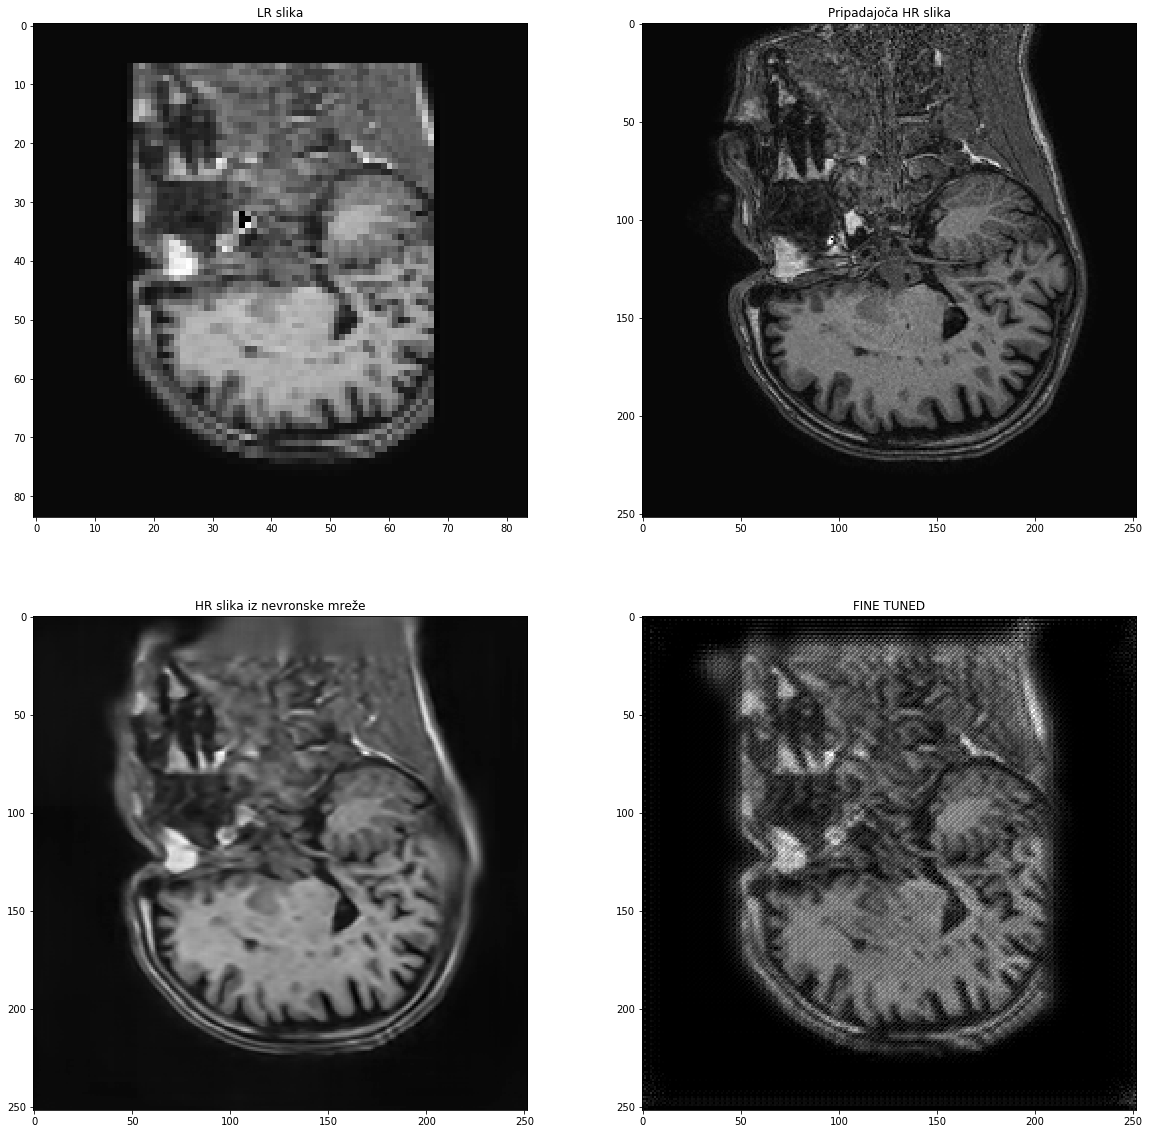

In [0]:
path="M_drive/My Drive/SeminarAMS/"
import sys
sys.path.append(path)
from PIL import Image
import scipy.misc
from model import resolve_single
edsr_pre_trained = edsr(scale=3, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000.h5'))


edsr_fine_tuned = edsr(scale=3, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'REAL_CROP_EDSR_300x1000_TUNED.h5'))

lr=X_test
hr=y_test
ix = random.randint(0, len(lr)-1)

sr_pt=resolve_single(edsr_pre_trained,lr[ix,:,:,:])
sr_ft = resolve_single(edsr_fine_tuned, lr[ix,:,:,:])



lr_im=(np.asarray(lr[ix,:,:,0])+np.asarray(lr[ix,:,:,1])+np.asarray(lr[ix,:,:,2]))/3
hr_im=(np.asarray(hr[ix,:,:,0])+np.asarray(hr[ix,:,:,1])+np.asarray(hr[ix,:,:,2]))/3
srpt_im=(np.asarray(sr_pt[:,:,0])+np.asarray(sr_pt[:,:,1])+np.asarray(sr_pt[:,:,2]))/3
srft_im=(np.asarray(sr_ft[:,:,0])+np.asarray(sr_ft[:,:,1])+np.asarray(sr_ft[:,:,2]))/3
print(np.asarray(hr[ix,:,:,:]).shape)
print(np.asarray(sr_pt).shape)



fig=plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(lr_im,cmap="gray")
plt.title("LR slika")
plt.subplot(222)
plt.imshow(hr_im,cmap="gray")
plt.title("Pripadajoča HR slika")
plt.subplot(223)
plt.imshow(srpt_im,cmap="gray")
plt.title("HR slika iz nevronske mreže")
plt.subplot(224)
plt.imshow(srft_im,cmap="gray")
plt.title("FINE TUNED")



